In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore', FutureWarning)



In [2]:
import numpy as np 
import pandas as pd 
import os
import scanpy as sc 

import sys
sys.path.append('../src')

In [3]:
# # CONGA c2_gex_donor2
# name = 'conga_c2_gex_donor2'
# results_dir = '/ix/djishnu/alw399/SLIDE_PLM/results/plm'
# esm_joint_embed = np.load(f'{results_dir}/{name}/esm2_pca16_joint_embed_fdr0.2_iters20_thresh_0.65.npy')
# pjm_joint_embed = np.load(f'{results_dir}/{name}/pjm_15epochs_pca16_joint_embed_fdr0.2_iters20_thresh_0.65.npy')
# y_path = '/ix/djishnu/alw399/SLIDE_PLM/data/conga/slide/inputs/c2gex_donor2_y.csv'
# slide_outs = '/ix/djishnu/alw399/SLIDE_PLM/data/conga/slide/outputs/c2gex_donor2/0.1_1_out'
# y = pd.read_csv(y_path)['is_c2'].values
# conga_adata = sc.read_h5ad('/ix/djishnu/alw399/SLIDE_PLM/data/conga/paper_data/10x_200k/donor2/donor2_conga.h5ad')
# sequences = conga_adata.obs['cdr3b']

# MAIT donor2
name = 'conga_mait_donor2'
results_dir = '/ix/djishnu/alw399/SLIDE_PLM/results/plm'
esm_joint_embed = np.load(f'{results_dir}/{name}/esm2_pca16_joint_embed_fdr0.4_iters20_thresh_0.65.npy')
pjm_joint_embed = np.load(f'{results_dir}/{name}/pjm_15epochs_pca16_joint_embed_fdr0.6_iters20_thresh_0.65.npy')
y_path = f'/ix/djishnu/alw399/SLIDE_PLM/data/conga/slide/inputs/mait_donor2_y.csv'
slide_outs = '/ix/djishnu/alw399/SLIDE_PLM/data/conga/slide/outputs/mait_donor2/0.01_0.5_out'
y = pd.read_csv(y_path)['is_mait'].values
conga_adata = sc.read_h5ad('/ix/djishnu/alw399/SLIDE_PLM/data/conga/paper_data/10x_200k/donor2/donor2_conga.h5ad')
sequences = conga_adata.obs['cdr3b']

In [4]:
from util import get_sigLFs

z1s = get_sigLFs(slide_outs)
z_matrix = pd.read_csv(os.path.join(slide_outs, 'z_matrix.csv'), index_col=0)
z_matrix = z_matrix[z1s]
z_matrix.shape

(6495, 68)

In [5]:
# Interactors did not contribute to signal
z_matrix = pd.DataFrame(z_matrix['Z79']) # MAIT donor2

In [6]:
sig_cells = conga_adata.obs['conga_scores'] <= 1
X = conga_adata.to_df()

In [7]:
from models import Estimator
from sklearn.linear_model import Lasso, LinearRegression

model = Lasso(alpha=0.05)
estimator = Estimator(model=model)

auc_gex = estimator.evaluate(X, y)
auc_z = estimator.evaluate(z_matrix, y)
auc_esm = estimator.evaluate(esm_joint_embed, y)
auc_pjm = estimator.evaluate(pjm_joint_embed, y)

auc_conga = estimator.evaluate(X[sig_cells], y[sig_cells])
auc_z_sig = estimator.evaluate(z_matrix[sig_cells], y[sig_cells])
auc_esm_sig = estimator.evaluate(esm_joint_embed[sig_cells], y[sig_cells])
auc_pjm_sig = estimator.evaluate(pjm_joint_embed[sig_cells], y[sig_cells])


In [8]:
df = pd.DataFrame(
    np.vstack([auc_gex, auc_z, auc_esm, auc_pjm, auc_conga, auc_z_sig, auc_esm_sig, auc_pjm_sig]),
    index=['gex', 'z1', 'ESM', 'PJM', 'CONGA', 'z1 (CONGA)', 'ESM (CONGA)', 'PJM (CONGA)']
)
df.reset_index(inplace=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

gex vs. z1: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01
PJM vs. CONGA: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.341e-05 Stat=1.632e+01
CONGA vs. z1 (CONGA): Kruskal-Wallis independent samples (pairwise between groups), P_val:1.562e-04 Stat=1.430e+01
gex vs. ESM: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01
ESM vs. CONGA: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.341e-05 Stat=1.632e+01
PJM vs. z1 (CONGA): Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01
CONGA vs. ESM (CONGA): Kruskal-Wallis independent samples (pairwise between groups), P_val:1.562e-04 Stat=1.430e+01
gex vs. PJM: Kruskal-Wallis independe

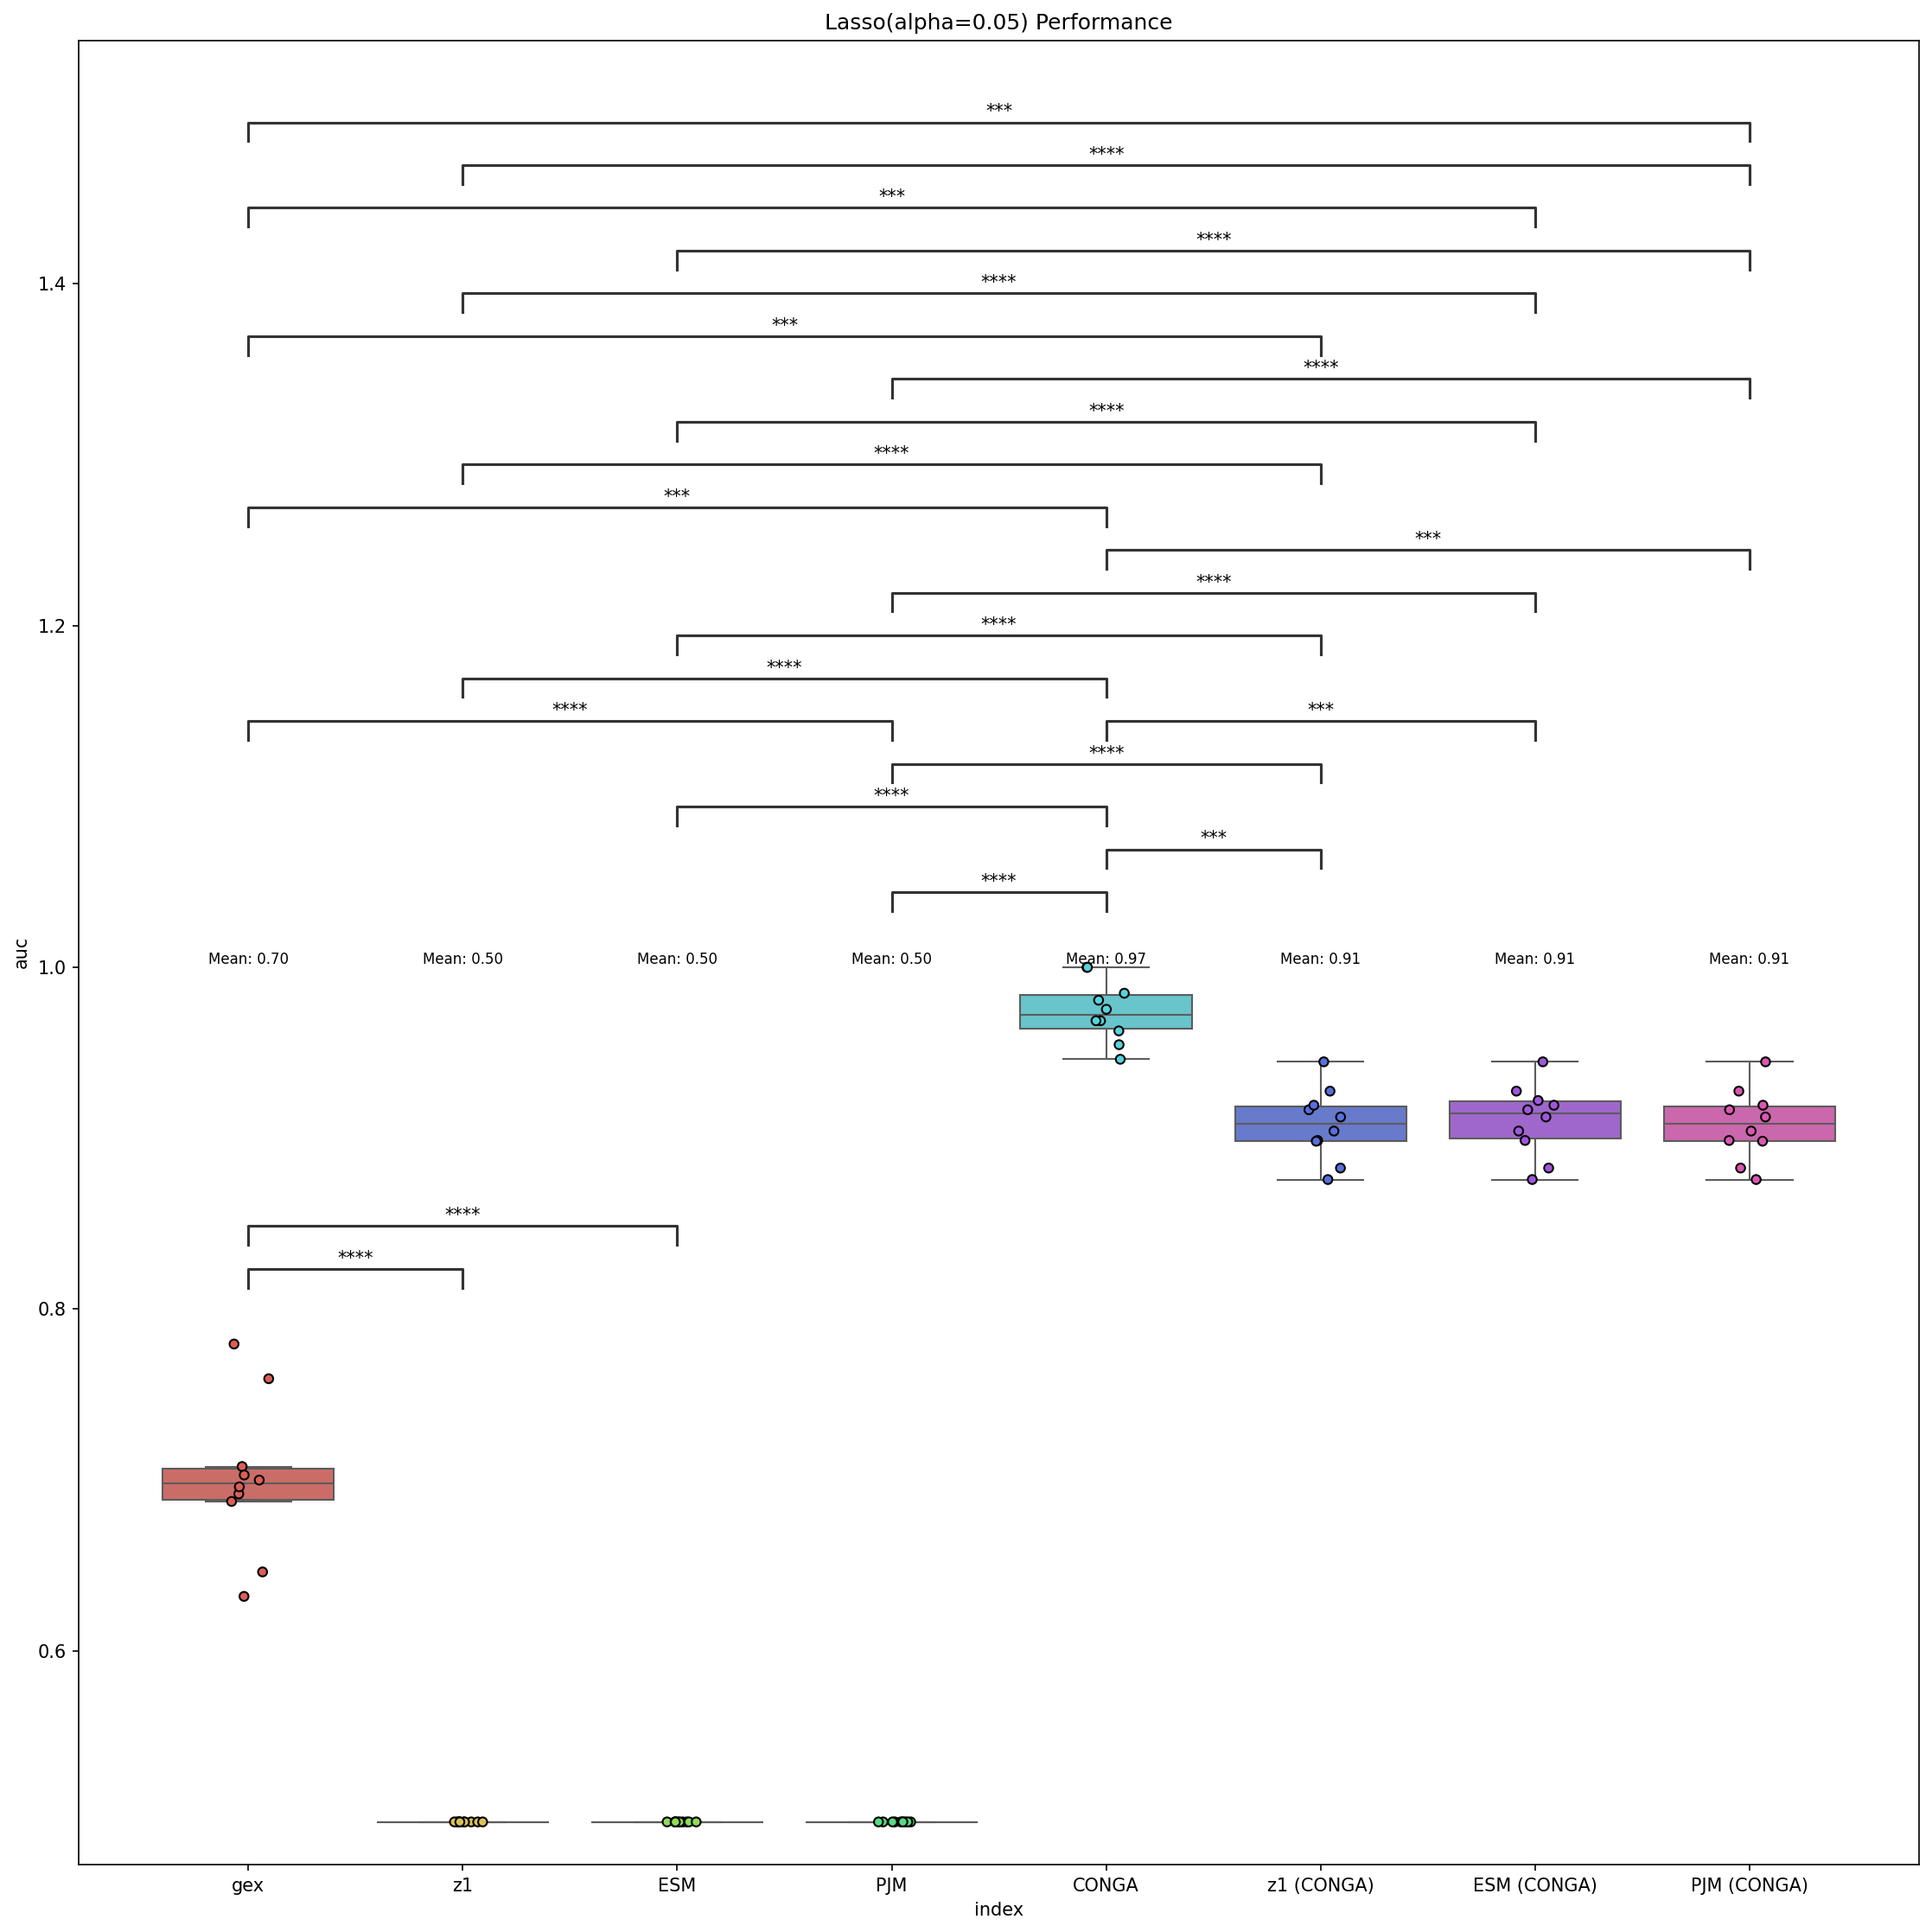

In [9]:
from plotting import show_performance
show_performance(
    model, df, 
    figsize = (15, 15),
    order = df['index'],
    save_path=f'/ix/djishnu/alw399/SLIDE_PLM/results/conga/{name}/{model.__class__.__name__}_performance.png')

In [10]:
from models import Estimator
from sklearn.linear_model import Lasso, LinearRegression

model = LinearRegression()
estimator = Estimator(model=model)

auc_gex = estimator.evaluate(X, y, scale_features=False)
auc_z = estimator.evaluate(z_matrix, y, scale_features=False)
auc_esm = estimator.evaluate(esm_joint_embed, y, scale_features=False)
auc_pjm = estimator.evaluate(pjm_joint_embed, y, scale_features=False)

auc_conga = estimator.evaluate(X[sig_cells], y[sig_cells], scale_features=False)
auc_z_sig = estimator.evaluate(z_matrix[sig_cells], y[sig_cells], scale_features=False)
auc_esm_sig = estimator.evaluate(esm_joint_embed[sig_cells], y[sig_cells], scale_features=False)
auc_pjm_sig = estimator.evaluate(pjm_joint_embed[sig_cells], y[sig_cells], scale_features=False)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

gex vs. z1: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.571e-04 Stat=1.429e+01
PJM vs. CONGA: Kruskal-Wallis independent samples (pairwise between groups), P_val:2.110e-04 Stat=1.373e+01
CONGA vs. z1 (CONGA): Kruskal-Wallis independent samples (pairwise between groups), P_val:4.928e-02 Stat=3.866e+00
gex vs. ESM: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.562e-04 Stat=1.430e+01
ESM vs. CONGA: Kruskal-Wallis independent samples (pairwise between groups), P_val:2.821e-04 Stat=1.319e+01
PJM vs. z1 (CONGA): Kruskal-Wallis independent samples (pairwise between groups), P_val:1.571e-04 Stat=1.429e+01
gex vs. PJM: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.571e-04 Stat=1.429e+01
z1 vs. CONGA: Kruskal-Wallis independent sample

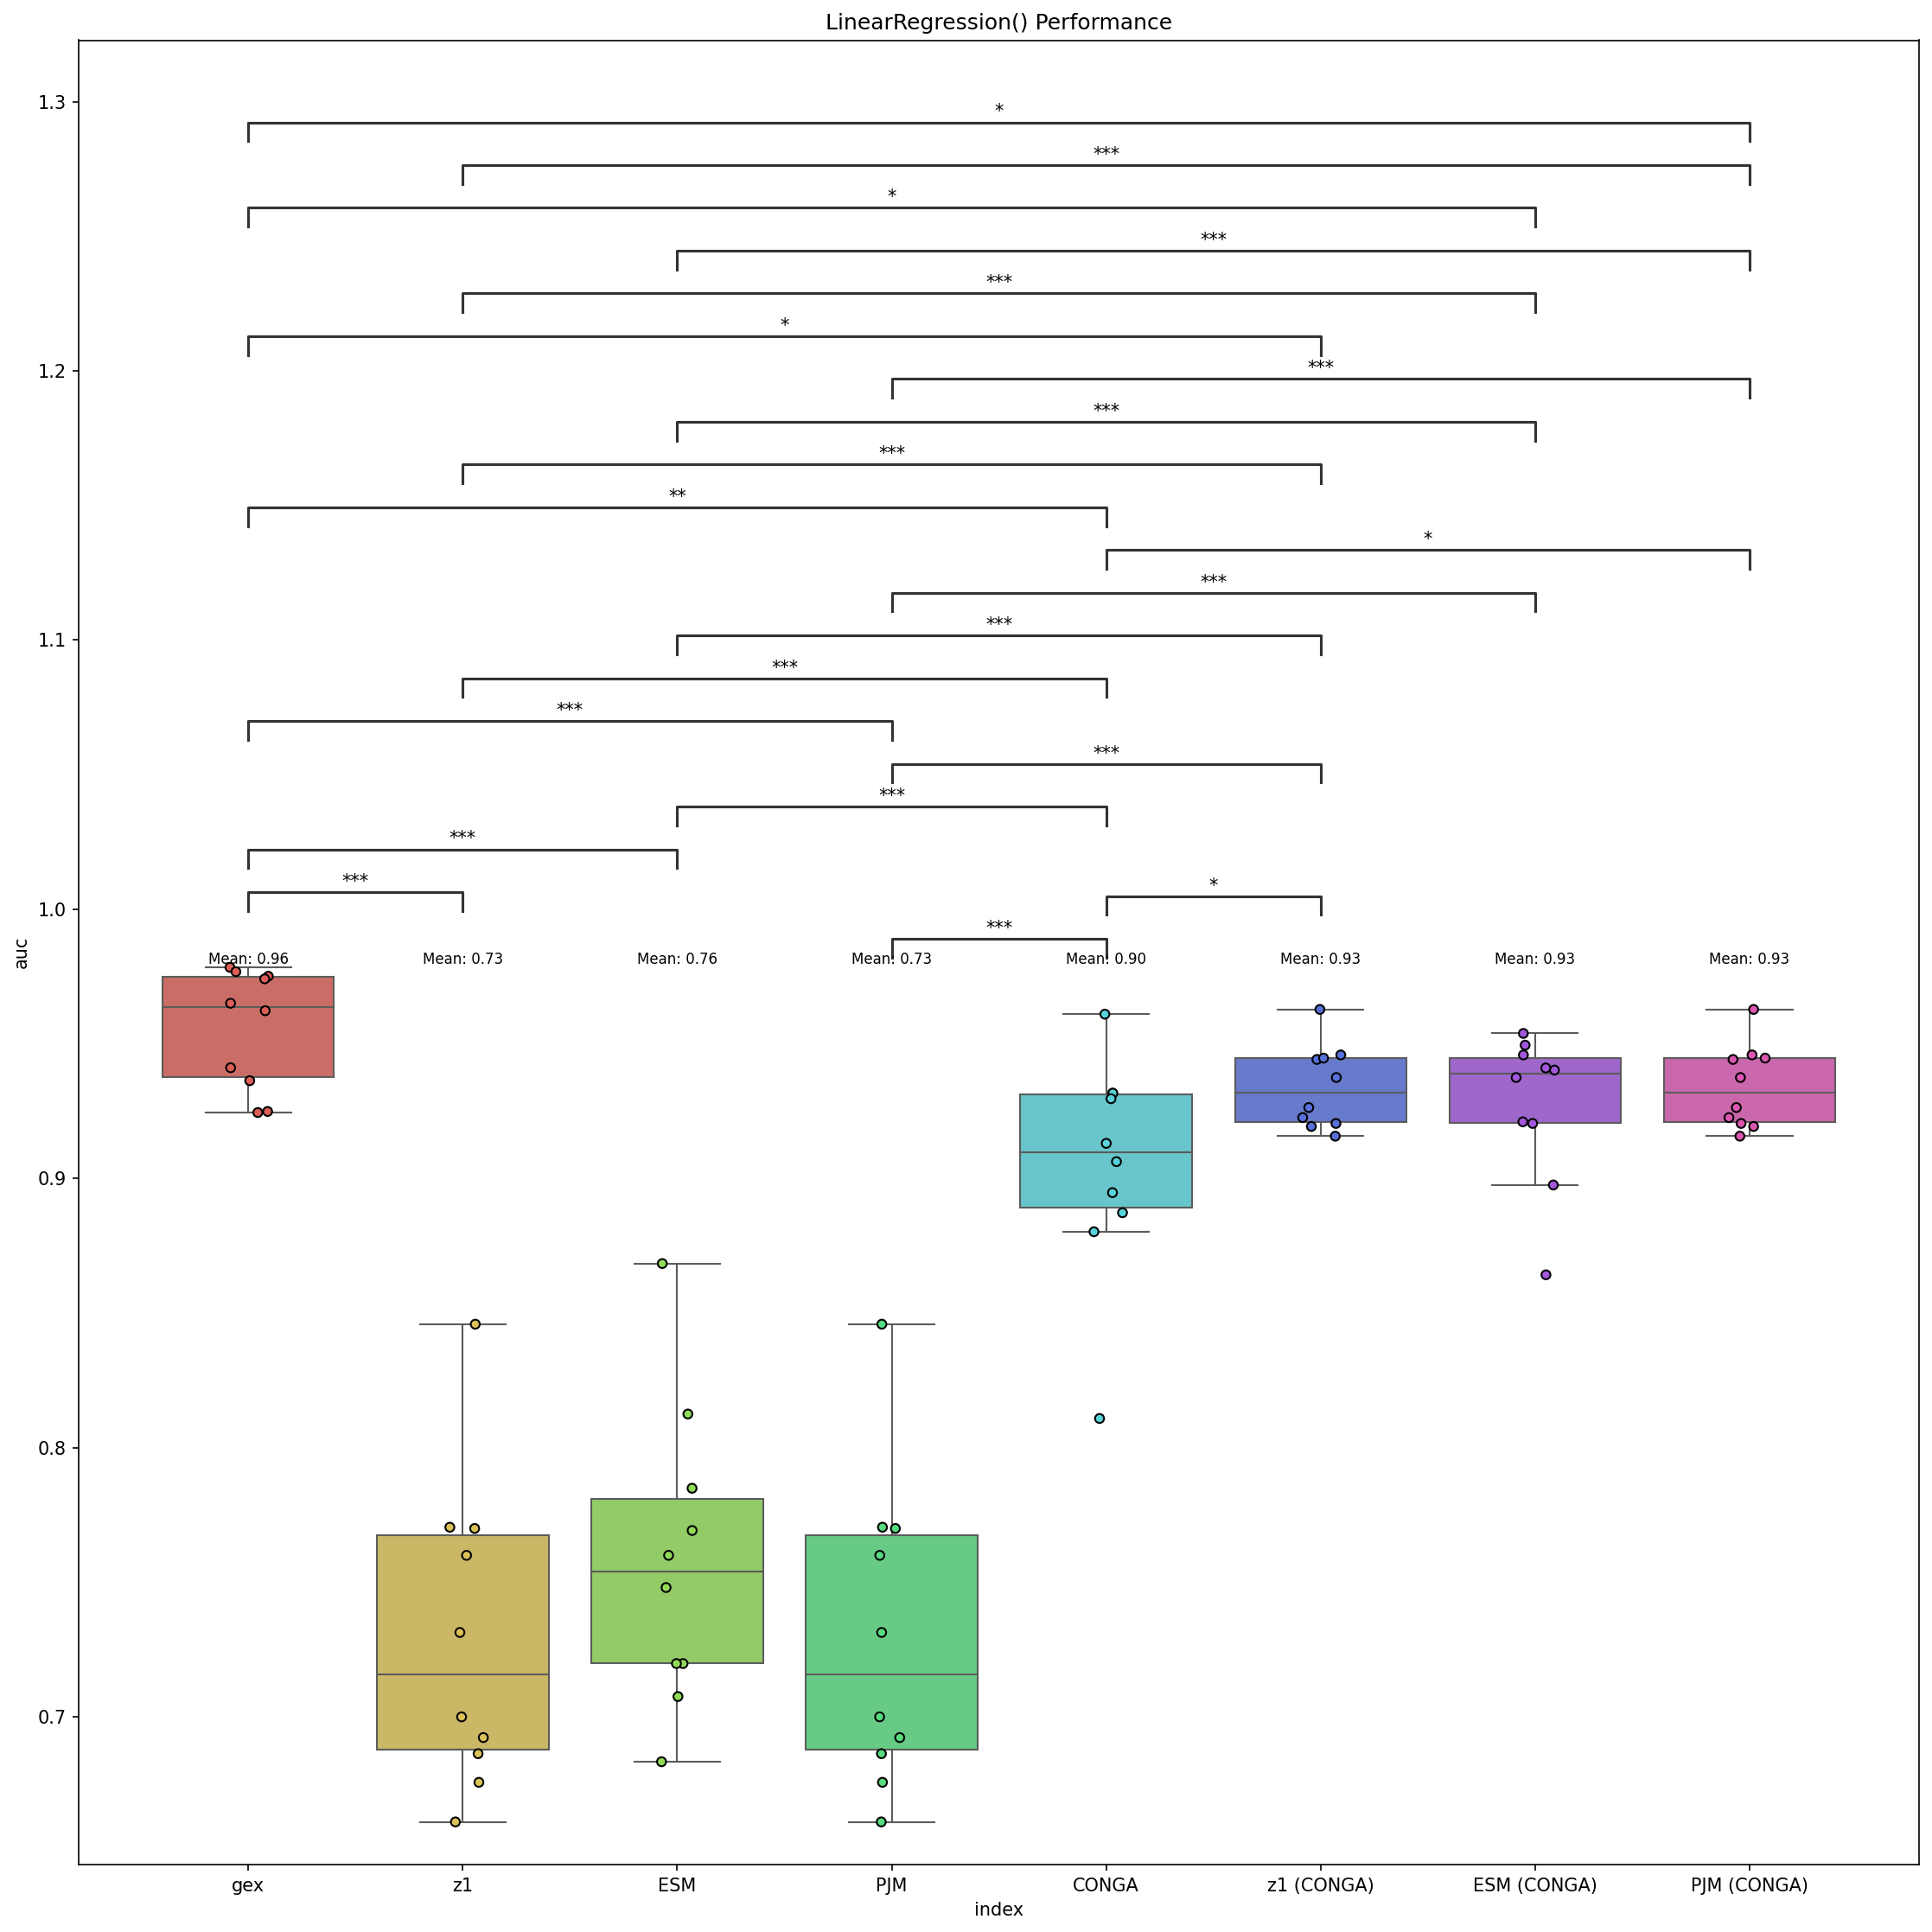

In [11]:
df = pd.DataFrame(
    np.vstack([auc_gex, auc_z, auc_esm, auc_pjm, auc_conga, auc_z_sig, auc_esm_sig, auc_pjm_sig]),
    index=['gex', 'z1', 'ESM', 'PJM', 'CONGA', 'z1 (CONGA)', 'ESM (CONGA)', 'PJM (CONGA)']
)
df.reset_index(inplace=True)

show_performance(
    model, df, 
    figsize = (15, 15),
    order = df['index'],
    save_path=f'/ix/djishnu/alw399/SLIDE_PLM/results/conga/{name}/{model.__class__.__name__}_performance.png')